# Data Science - Final Assignment.
# Author: Anton Thorsen 202004932

The goal of the assignment is to implement two controllers for the _Pendulum_ environment of the _Gym_ library: a model-based controller and a model-free, neural network-based controller. Please **read carefully** the [documentation](https://gymnasium.farama.org/environments/classic_control/pendulum/) of environment before starting (focus on the state variables and controls). 

The solution **must** be provided as a _Jupyter_ notebook, with all the cells evaluated. Use comments in the code and/or _Markdown_ cells to clarify some particular choices you took while solving the assignment (to overcome some issues or, for instance, the choice of hyperparameters to tune).

For this assignment you will need to use some Python libraries. Here is a list of (potentially) useful imports:

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import pygmo as pg
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

ModuleNotFoundError: No module named 'tabulate'

## Part 1: Model Predictive Control

Implement a model-based controller that uses the Model Predictive Control (MPC) theory (see the slides in the _Genetic Algorithm_ set in the repo of the course) to **stabilize the pendulum in its upright position** ($\theta = 0$, $\omega = 0$). Please set the **gravity equal to 9.81** using the `g` argument of the `Pendulum-v1` environment. In general, you should follow these steps:

1. Define the _cost_ function associated to the MPC: it must include the cost associated to the difference between the state of the system and the setpoints for the angle and the angular velocity. For the prediction of the future states, create another _Pendulum_ environment called `env_mpc` (separate from the one `main_env` that the controller is interacting with) and every time the cost function is evaluated initialize its state with the current state of the main environment using the following instruction: `env_mpc.unwrapped.state = main_env.unwrapped.state`. The main environment `main_env` should be passed as a parameter to the cost function.
2. Define a function to play a "game" using a controller chosen by the user among the following: 1) MPC; 2) random; 3) Neural Network (see Part 2). The _initial conditions_ (angle and angular velocity) should be passed as parameters to this function and set appropriately at the beginning of the game using the `env.unwrapped.state` variable. For the MPC controller, at each time step an optimization problem must be solved that minimizes the cost function defined in Step 1 with respect to the control sequence (over the control horizon). The appropriate action should then be taken. Remember that the control variable has some bounds... The function should store and return the lists of _observations_ and corresponding _controls_ and the _total score_ associated to the game.
3. Play _a few_ games with _random_ initial conditions (angle between -20 and +20 degrees and angular velocity between -0.1 and 0.1 rad/s) and compute the _average total score_. **You should get a total score above -10, at least in some games.** For one game, plot the angle and the angular velocity as a function of time, and the controls in a separate figure.

Initializing the environment:

In [2]:
main_env = gym.make('Pendulum-v1',g=9.81)

horizon = 10 #horizon = 5, gen=4 and population; size = 10 leads to OK results at decent computations times 

Defining the cost function:

In [3]:
def cost_function(params, action, horizon):    
    env_mpc = gym.make('Pendulum-v1', g=9.81)
    state,_ = env_mpc.reset()
    env_mpc.unwrapped.state = params #main_env.unwrapped.state
    
    weight_theta = 0.1
    weight_omega = 0.1  
    weight_action = 0.001  
    theta_setpoint = 0
    omega_setpoint = 0  
    cost = 0
    for act in action: #runs 10 times because horizon=10
        obs, _, _, _,_ = env_mpc.step([act])
        cos_theta, sin_theta, omega = obs        #The observation space is x, y and omega
        theta = np.arctan2(sin_theta, cos_theta) #theta is needed, not x or y
        cost += weight_theta * ((theta - theta_setpoint)**2 + weight_omega * (omega - omega_setpoint) ** 2 + weight_action * act ** 2)
    return cost

Defining the tuning class:

In [4]:
class MPC_tuning:
    def __init__(self,params,horizon):
        self.params = params
        self.horizon = horizon
        
    def fitness(self, action):
        cost = cost_function(self.params, action, self.horizon) #this cost is computed 500 times at 30x30 gen pop, and 100 times if 10x10 gen pop
        return [cost]

    def get_bounds(self):
        return ([-2.]*self.horizon, [2.]*self.horizon) #Defines the bounds of the action [Torque]

Defining the function used to a play a single game with a controller of choice:

In [5]:
def play_game(initial_state, env, controller, printing=False, model=None):
    terminated = False
    truncated = False
    state, _ = env.reset()
    env.unwrapped.state = initial_state  #Initializing the state
    
    observations = []
    controls = []
    total_score = 0
    counter = 0  
    prev_obs = initial_state
    #horizon = 5 #unnecessary
    
    while not (terminated or truncated):
        if controller == "RANDOM":
            action = env.action_space.sample()[0]
        
        elif controller == "MPC":
            prob = pg.problem(MPC_tuning(prev_obs, horizon))
            algo = pg.algorithm(pg.sga(gen=10)) #Simple genetic algorithm
            pop = pg.population(prob, size=10)
            pop = algo.evolve(pop)           
            best_controls = pop.champion_x     #Finding best controls
            action = best_controls[0]
            
        elif controller == "NN":
                x_obs = np.cos(prev_obs[0])
                y_obs = np.sin(prev_obs[0])
                prev_obs_NN = torch.tensor([x_obs,y_obs,prev_obs[1]],dtype=torch.float32)
                prev_obs_NN = prev_obs_NN.reshape(1,-1)
                #prev_obs_NN = torch.tensor([prev_obs])
                action = model.predict(prev_obs_NN).item()

        controls.append(action)
        obs, reward, terminated, truncated, _ = env.step([action])
        theta = np.arctan2(obs[1],obs[0])
        omega = obs[2]
        obs = [theta,omega]
        observations.append(obs)
        prev_obs = obs #Need it to be a [3,] array not a [3,1] for prev_obs to be the correct shape for action = model.predict(prev_obs).item()
        total_score += reward
        
        if printing == True: #If desired the duration of the interation can be followed
            counter += 1
            if counter % 100 == 0:
                print(f'Iteration: {counter}/200 max')
    return observations, controls, total_score

Defining a play function to play multiple games:

In [6]:
def play_X_games(num_games, controller, env, printing = False, model = None):
    scores = []
    obs = []
    action = []
    if controller == 'MPC':
        print('Controller: MPC')
    elif controller == 'RANDOM':
        print('Controller: RANDOM')
    elif controller =='NN':
        print('Controller: NN')
    for i in range(num_games):
        initial_conditions = [np.random.uniform(-20*np.pi/180, 20*np.pi/180), np.random.uniform(-0.1, 0.1)]
        if printing == True:
            print(f'Game no. {i+1}/{num_games} ')
        observations, controls, total_score = play_game(initial_conditions, env, controller, printing, model) #Calling the play_game function
        scores.append(total_score)
        obs.append(observations)
        action.append(controls)
        if printing == True:
            print()
    if printing == True:
        print(f'Scores from {num_games} games: \n{np.around(np.array(scores), decimals=4)} \n')
    print(f'Average Score [{controller}]: {np.sum(scores)/num_games:.4f}\n')
    return obs, action, scores

The function for generated training data is created. About 2000 sets of observations+actions should be sufficient: Note that the generation size is smaller than for the play_game function to lessen the computation time. This does cause the occasional bad game-score but it is, however, still sufficiently accurate for most games and the function filters away the bad scores:

In [7]:
def generate_training_data(num_games, env, printing = False):
    training_data = []
    counter = 0
    for i in range(num_games):
        score = 0
        initial_cond = [np.random.uniform(-20*np.pi/180, 20*np.pi/180), np.random.uniform(-0.1, 0.1)]
        state, _ = env.reset()
        env.unwrapped.state = initial_cond
        game_memory = []
        prev_obs = initial_cond
        terminated = False
        truncated = False
        while not (terminated or truncated):
            prob = pg.problem(MPC_tuning(prev_obs, horizon))
            algo = pg.algorithm(pg.sga(gen=3)) #Simple genetic algorithm
            pop = pg.population(prob, size=10)
            pop = algo.evolve(pop)           
            best_controls = pop.champion_x     #Finding best controls
            action = best_controls[0]
            
            obs, reward, terminated, truncated, _ = env.step([action])
            
            if len(prev_obs) > 0:
                game_memory.append([prev_obs, action])
            
            theta = np.arctan2(obs[1],obs[0])
            omega = obs[2]
            obs = [theta,omega]
            prev_obs = obs
            score += reward                     
            
        if score > -2: #If the score of a game is sufficiently good - store it
            for data in game_memory:
                angle = data[0][0]
                observations = [np.cos(angle),np.sin(angle), data[0][1]]
                actions = data[1]
                training_data.append([observations, actions])  
        if printing == True:
            counter += 1
            print(f'Datasets generated: {counter*200}')
            print(f"Score: {score:.4f}")    
    return training_data

For convenience a plotting function is created:

In [8]:
def plot_res(observations, controls):
    observations = np.array(observations)
    plt.figure(figsize=(7, 5))
    for i in range(len(observations)):
        theta = observations[i,:,0]
        angular_velocities = observations[i,:,1]
        plt.subplot(3, 1, 1)
        plt.plot(theta)
        plt.title('Angles')
        plt.xlabel('Steps')
        plt.ylim([-np.pi, np.pi])
        plt.ylabel('Angle')
    
        plt.subplot(3, 1, 2)
        plt.plot(angular_velocities)
        plt.title('Angular Velocities')
        plt.xlabel('Steps')
        plt.ylim([-8, 8])
        plt.ylabel('Angular Velocity')
    
        plt.subplot(3, 1, 3)
        plt.plot(controls[i])
        plt.title('Controls')
        plt.xlabel('Steps')
        plt.ylabel('Control')
    
    plt.tight_layout()
    plt.show()

A function for rendering the pendulum is created. It needs the initial_conditions fed to a play_game function and the
controls the play_game function outputs:

In [9]:
def rendering(initial_conditions, controls):
   # Initialize the environment
   env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
   state, _ = env.reset()
   env.unwrapped.state = initial_conditions
   observations = []
   terminated = False
   truncated = False
   # Step through the environment using your controls
   while not (terminated or truncated):
       for control in controls:
           obs, reward, terminated,truncated, info = env.step([control])
           observations.append(obs)
       env.close()
   if truncated:
       print('\nRendering truncated \n') 

5 games with a random controller and the MPC controller is played and their average scores computed for comparison:

In [10]:
num_games = 5
observations_rand, controls_rand, total_scores_rand = play_X_games(num_games, 'RANDOM', main_env)

observations_mpc, controls_mpc, total_scores_mpc = play_X_games(num_games, 'MPC', main_env, printing = True)

Controller: RANDOM
Average Score [RANDOM]: -847.1732

Controller: MPC
Game no. 1/5 
Iteration: 100/200 max
Iteration: 200/200 max

Game no. 2/5 
Iteration: 100/200 max
Iteration: 200/200 max

Game no. 3/5 
Iteration: 100/200 max
Iteration: 200/200 max

Game no. 4/5 
Iteration: 100/200 max
Iteration: 200/200 max

Game no. 5/5 
Iteration: 100/200 max
Iteration: 200/200 max

Scores from 5 games: 
[  -0.8055   -1.0298   -0.9919 -128.626    -1.1499] 

Average Score [MPC]: -26.5206



For rendering if desired:

Plotting for 1 game:

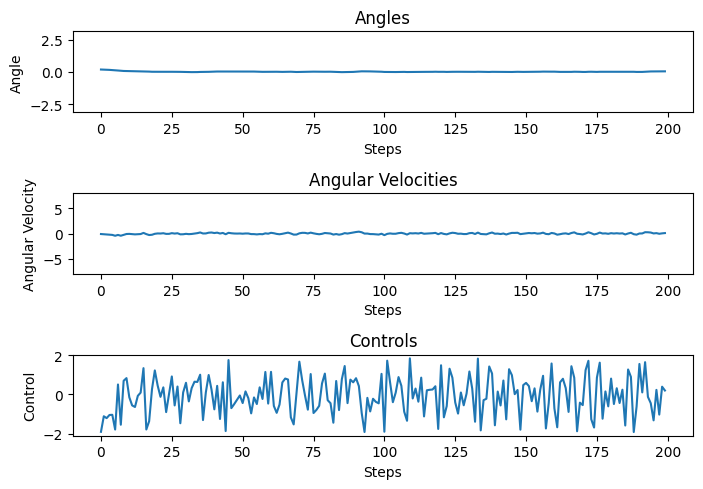

In [11]:
plot_res([observations_mpc[0]],[controls_mpc[0]])

The figure above shows that the MPC controller is able to stabilize the pendulum

For rendering, if desired:

In [15]:
initial_conditions = [np.random.uniform(-20*np.pi/180, 20*np.pi/180), np.random.uniform(-0.1, 0.1)]
observations, controls, total_score = play_game(initial_conditions, main_env, 'MPC')
rendering(initial_conditions, controls)


Rendering truncated 



## Part 2: Neural Network controller

In this part, you will train a neural-network based controller based on the optimal control strategy found in Part 1. To this aim you should:
1. Create a feedforward neural network that takes the current **observation** ($x$, $y$, $\omega$) as an input and returns the **control** to be applied to the system. Make sure that the returned value is "admissible".
2. Generate a training dataset by playing a certain number of games (suggested minimum 100) using the functions implemented in Part 1 and providing as random initial conditions an angle between -20 and 20 degrees and zero angular velocity. Note: this step may be _slow_. Remember to convert the dataset to `torch` tensors with float32 precision.
3. **Train** and **select** the network (by exploring different _architectures_ and values for the _hyperparameters_).
4. Play 2000 games using the function implemented in Step 1 with the controls given by the "best" network. Compute the average total score. **You should get an average score above -2.** Compare the average total score with that of a _random controller_.

Generating training data. The MPC controller is quite good, and for that reason 20 games will be sufficient to generate 2000 sets of observations+actions that have a score above -2:

In [16]:
training_data = generate_training_data(20, main_env, printing = True)

Datasets generated: 200
Score: -251.6636
Datasets generated: 400
Score: -0.8446
Datasets generated: 600
Score: -129.8407
Datasets generated: 800
Score: -0.9749
Datasets generated: 1000
Score: -0.9061
Datasets generated: 1200
Score: -1.3858
Datasets generated: 1400
Score: -1.0008
Datasets generated: 1600
Score: -382.9985
Datasets generated: 1800
Score: -1.1336
Datasets generated: 2000
Score: -0.7199
Datasets generated: 2200
Score: -127.4207
Datasets generated: 2400
Score: -1.0936
Datasets generated: 2600
Score: -0.9138
Datasets generated: 2800
Score: -0.6867
Datasets generated: 3000
Score: -0.7918
Datasets generated: 3200
Score: -127.8469
Datasets generated: 3400
Score: -1.3114
Datasets generated: 3600
Score: -129.1428
Datasets generated: 3800
Score: -0.7691
Datasets generated: 4000
Score: -1.0728


Note that there were 5 occurrences in the above with a lower score than -2. These are NOT stored in training_data, but they are still printed if printing is set to true.

Next; Initializing the generated data, picking the first 2000 entries, and converting to tensors:

In [18]:
from sklearn.model_selection import train_test_split
X = np.array([entry[0] for entry in training_data[:2000]])
y = np.array([entry[1] for entry in training_data[:2000]]).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_ = torch.tensor(X_train, dtype=torch.float32)
y_ = torch.tensor(y_train, dtype=torch.float32)

In [19]:
#%% Defining the neural network
class NN(nn.Module): #Simple network with only 1 hidden layer
    def __init__(self,num_units=32):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, num_units), #3 for the observations
            nn.ReLU(),
            nn.Linear(num_units,1),
            nn.Tanh()             
        )
    def forward(self, x):
        x = x.to(torch.float32)
        y = 2*self.linear_relu_stack(x) #Combined with Tanh it makes sure the bounds of the action goes from -2 to 2
        return y 

Defining the NeuralNetRegressor model:

In [20]:
epochs = 100
lr = 0.01

from skorch.callbacks import EarlyStopping #This stops the epochs if validation starts to go up

model = NeuralNetRegressor(module=NN, lr=lr, verbose=0, iterator_train__shuffle = True,
                           max_epochs=epochs, module__num_units=32, 
                           callbacks=[('estoper',EarlyStopping(patience=30)),])

ModuleNotFoundError: No module named 'tabulate'

Defining the pipeline:

In [ ]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('model',model),
])
pipe.fit(X_, y_) #Fitting model using the parameters that was specified in class NN

Plotting the training and validation loss:

In [ ]:
train_loss = pipe['model'].history[:, 'train_loss']
valid_loss = pipe['model'].history[:, 'valid_loss']
epochs = [i for i in range(1,len(train_loss)+1)]
plt.figure()
plt.plot(epochs, train_loss, label='training loss')
plt.plot(epochs, valid_loss, label='validation loss')
plt.title('Pipe: Losses')
plt.legend()
plt.show()

Training and validation follow each other nicely in the plot above, however a gridsearch will still be conducted.
The gridsearch is used to (in this case) determine the best parameters of num_units and learning rate. This is done to find the architecture of the neural network that leads to the smallest degree of overfitting/underfitting

In [ ]:
params = {
    "model__module__num_units": [10, 20, 40],
    "model__lr": [0.001,0.005, 0.01],
}
gs = GridSearchCV(pipe,params,verbose=0) 
gs.fit(X_, y_) 
print("\ngs.best_score_: %0.4f:" % gs.best_score_)
print(gs.best_params_)
print()

model_info = gs.best_estimator_['model'].history
train_loss = model_info[:,'train_loss']
valid_loss = model_info[:,'valid_loss']
plt.figure()
plt.plot(train_loss, label = 'Training Loss')
plt.plot(valid_loss, label = 'Validations Loss')
plt.title('gs: Losses')
plt.legend()

As can be seen in the above figure, the gridsearch manages to find some parameters that improves the controller

Playing 2000 games with a random controller and the neural network controller to compare their performances.

In [ ]:
num_games = 2000 
obs_rand, controls_rand, scores_rand = play_X_games(num_games, 'RANDOM', main_env)
obs_NN, controls_NN, scores_NN = play_X_games(num_games, 'NN', main_env, model=gs)


plt.figure()
plt.plot(scores_NN, label = 'Neural Network')
plt.plot(scores_rand, label = 'Random')
plt.xlabel('Game')
plt.ylabel('Score')
plt.title('Comparison of scores for NN and random controller')
plt.legend(loc='center right')

The neural network controller performs, as expected, very well, with an average score of just -0.4154. Especially compared to the score of the random controls of -891.8858

Plotting 5 games on top:

In [ ]:
plot_res(obs_NN[-5:],controls_NN[-5:])

These figures show that for these 5 NN games the controller is able to stabilize the pendulum

Rendering of a single neural network game, if desired:

In [ ]:
initial_conditions = [np.random.uniform(-20*np.pi/180, 20*np.pi/180), np.random.uniform(-0.1, 0.1)]
observations, controls, total_score = play_game(initial_conditions, main_env, 'NN', model=gs)
rendering(initial_conditions, controls)